In [11]:
import pandas as pd
import numpy as np
from data_master import DataMaster
from utils import func
from scipy.stats import norm
master = DataMaster()

In [13]:
universe = master.baskets.get_index_historical_components('GSPC')
P = func.presence_matrix(universe).loc['2008':]

In [36]:
market_data = pd.read_parquet('data/SP500/mkt_data.pq')
balance_sheet = pd.read_parquet('data/SP500/balance_sheets.pq')
GICS = pd.read_parquet('data/SP500/GICS.pq')

R = market_data['close'].unstack().pct_change()

In [37]:
metrics = (-balance_sheet['netDebt'].astype(float)/balance_sheet['cash'].astype(float))
netdebt = metrics.unstack().ffill()
netdebt = netdebt.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt.index = pd.to_datetime(netdebt.index)
netdebt = netdebt.rolling(10).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
netdebt = netdebt.reindex_like(P).ffill()



C:\Users\marti\AppData\Local\Temp\ipykernel_90940\322947803.py:5: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  netdebt = netdebt.rolling(10).rank(axis=0,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)


In [38]:
def center(x):
    mean = x.mean(1)
    x = x.sub(mean,0)
    return x

In [39]:

thresh =0.1
SIGNAL = netdebt.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS['gicgrp'],axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_90940\514925842.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS['gicgrp'],axis=1).apply(center)


In [43]:
market_data

,,datetime,open,high,low,close,adj_close,volume,MktCap
Date,Ticker,,,,,,,,
2008-01-02,HAS,2008-01-02,25.52,25.77,24.87,25.00,16.0221,1622100,NaN
2008-01-03,HAS,2008-01-03,25.02,25.22,24.65,24.68,15.8170,1156800,NaN
2008-01-04,HAS,2008-01-04,24.45,24.49,23.67,23.74,15.2145,3502600,NaN
2008-01-07,HAS,2008-01-07,23.93,23.96,23.40,23.67,15.1697,1518300,NaN
2008-01-08,HAS,2008-01-08,23.75,23.95,23.25,23.42,15.0095,3185600,NaN
...,...,...,...,...,...,...,...,...,...
2023-03-29,ES,2023-03-29,76.47,77.70,76.47,77.55,77.5500,1510200,NaN
2023-03-30,ES,2023-03-30,77.75,78.23,77.34,78.11,78.1100,1092200,NaN
2023-03-31,ES,2023-03-31,78.38,78.48,77.47,78.26,78.2600,1734900,NaN


nan


<Axes: >

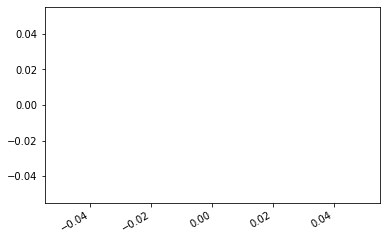

In [31]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()

SIGNAL LOW / CLOSE

In [195]:
metrics = pd.DataFrame(market_data['low'].divide(market_data['close']),dtype=float)
metrics.columns =['metrics']
metrics= metrics['metrics'].unstack().diff(26)
metrics = metrics[P].rank(1,pct=True,ascending=False).clip(0.01,0.99)
# metrics = metrics.stack().groupby(level=1).rolling(10).rank(pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf).droplevel(0)

# metrics = metrics.rolling(10).rank(axis=0,pct=True,asceneing=True)


In [196]:

thresh =0.25
SIGNAL = metrics.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\702060786.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


-1.162540367664539


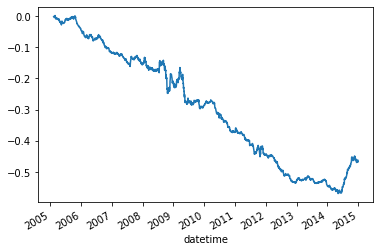

In [198]:
pnl = (SIGNAL.shift(1) *R).loc[:'2014'].sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()



ALPHA 20

In [163]:
from scipy.stats import skew

In [188]:
returns = R.rolling(15).sum()
skew = returns.rolling(15).skew(axis=0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\1598711166.py:2: FutureWarning: Passing additional kwargs to Rolling.skew has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  skew = returns.rolling(15).skew(axis=0)


In [189]:
alpha  = skew.diff(15)
alpha = alpha.rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)

In [190]:
thresh =0.25
SIGNAL = alpha.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\3200654778.py:6: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


-0.04375543898406448


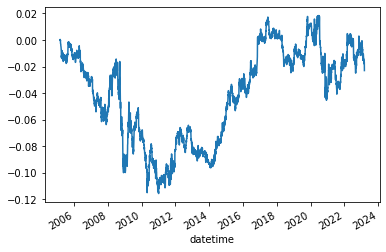

In [191]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()

In [199]:
# ALPHA 28

In [268]:
# RSI
ups = pd.DataFrame(R[R>0].rolling(5,min_periods=1).mean().stack(),columns =['UPS'])
downs = pd.DataFrame(R[R<0].rolling(5,min_periods=1).mean().abs().stack(),columns =['DOWNS'])
RS = ups.join(downs)
RS.dropna()

UPS     DOWNS
datetime   Ticker                    
2005-01-05 AAP     0.001849  0.006659
           ABK     0.009963  0.013230
           ABS     0.001290  0.021053
           ACAS    0.014041  0.027609
           ADI     0.004520  0.027205
...                     ...       ...
2023-03-10 XRAY    0.013681  0.015219
           ZBH     0.006627  0.011514
           ZBRA    0.016250  0.021539
           ZION    0.005168  0.048879
           ZTS     0.009639  0.015795

[3060184 rows x 2 columns]

In [269]:
RS['ALPHA'] = RS['UPS'].divide(RS['DOWNS'],0)

In [270]:
RSI = 100 - (100/(1+RS['ALPHA']))
RSI = pd.DataFrame(RSI,dtype=float)
RSI

ALPHA
datetime   Ticker           
2005-01-04 AAPL          NaN
           AIG           NaN
           AN            NaN
           ANF           NaN
           ANSS          NaN
...                      ...
2023-03-10 XRAY    47.339069
           ZBH     36.530519
           ZBRA    43.001886
           ZION     9.562059
           ZTS     37.897612

[3194160 rows x 1 columns]

In [271]:
ALPHA = RSI['ALPHA'].unstack()[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
ALPHA = ALPHA.rolling(5,min_periods=1).rank(axis=0,pct=True,ascending=False)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\4070706341.py:2: FutureWarning: Passing additional kwargs to Rolling.rank has no impact on the result and is deprecated. This will raise a TypeError in a future version of pandas.
  ALPHA = ALPHA.rolling(5,min_periods=1).rank(axis=0,pct=True,ascending=False)


In [272]:

thresh =0.5

SIGNAL = ALPHA.copy()
SIGNAL = SIGNAL[P].rank(1,pct=True,ascending=True).clip(0.01,0.99).apply(norm.ppf)
SIGNAL[SIGNAL.abs()<thresh] = None

SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)
# SIGNAL = SIGNAL.sub(SIGNAL.mean(1),0)
SIGNAL= SIGNAL.div(SIGNAL.abs().sum(1),0)

C:\Users\marti\AppData\Local\Temp\ipykernel_28524\1384291576.py:7: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  SIGNAL = SIGNAL[P].groupby(GICS,axis=1).apply(center)


0.5088427287919342


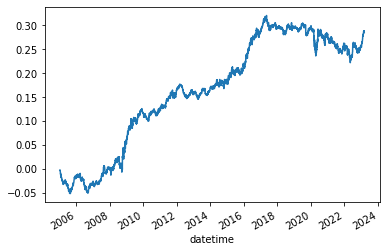

In [273]:
pnl = (SIGNAL.shift(1) *R).sum(1).replace({0:np.nan}).dropna()
sharpe = (pnl.mean(skipna=True)* np.sqrt(252)/ pnl.std(skipna=True))
print(sharpe)
pnl.cumsum().plot()
plt.show()